# Discovery and characterization of small-molecule TGR5 ligands with agonistic activity

**M. Giovanna E. Papadopoulos<sup>a</sup>, Alexander F. Perhalb<sup>b</sup>, Brian Medel-Lacruz<sup>c</sup>, Angela Ladurner<sup>b</sup>, Jana Selent<sup>c</sup>, Verena M. Dirsch<sup>b</sup>, Peter Kolb<sup>a</sup>**
<sup>a</sup>Department of Pharmaceutical Chemistry, University of Marburg, Marburg, Germany  
<sup>b</sup>Department of Pharmaceutical Sciences, University of Vienna, Vienna, Austria  
<sup>c</sup>Research Programme on Biomedical Informatics (GRIB), Department of Experimental and Health Sciences, Hospital del Mar Medical Research Institute (IMIM), Pompeu Fabra University (UPF), Barcelona, Spain  

<sup>1</sup> These authors contributed equally.

This notebook contains the scripts for the analysis of the Molecular Simulations presented in the publication. 

We provide the code to reproduce the plots and figures shown.

##### This notebook requires

- MDanalysis 
- Matplotlib 
- Spicy 
- Numpy 
- Pandas

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms, distances, contacts
from MDAnalysis.analysis.distances import dist
from scipy.signal import savgol_filter

C:\Users\Gio\AppData\Local\Temp\ipykernel_17936\761303659.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Gio\anaconda3\envs\mda\Lib\site-packages\Bio\Application\__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


## Main Functions

In [2]:
def calculate_distances(u, selection1, selection2):
    """
    Calculate the distances between the center of geometry of two selections
    in each frame of a molecular dynamics trajectory.

    Parameters:
    - u (MDAnalysis.core.universe.Universe): MDAnalysis Universe object representing the molecular system.
    - selection1 (str): Atom selection string for the first group of atoms.
    - selection2 (str): Atom selection string for the second group of atoms.

    Returns:
    - frames (list): List of frame indices.
    - distances (list): List of distances between the centers of geometry for each frame.
    """

    # Temporary lists to store distances and frame indices
    tmp_list = []
    frames = []

    # Loop through each frame in the trajectory
    for ts in u.trajectory:
        # Calculate the center of geometry for each selection
        pos1 = u.select_atoms(selection1).center_of_geometry()
        pos2 = u.select_atoms(selection2).center_of_geometry()

        # Calculate the Euclidean distance between the two center of geometry positions
        dist_numpy = np.linalg.norm(pos1 - pos2)

        # Append the distance and frame index to the temporary lists
        tmp_list.append(dist_numpy)
        frames.append(u.trajectory.frame)

    # Return the lists of frame indices and distances
    return frames, tmp_list

def smooth(y, window_size, order):
    """
    Apply Savitzky-Golay smoothing to a 1-D array.

    Parameters:
    - y (array_like): 1-D array containing the data to be smoothed.
    - window_size (int): The size of the smoothing window. Should be an odd integer.
    - order (int): The order of the polynomial used to fit the samples.

    Returns:
    - y_smooth (ndarray): The smoothed array.
    """
    # Apply Savitzky-Golay smoothing using scipy's savgol_filter
    y_smooth = savgol_filter(y, window_size, order)
    
    # Return the smoothed array
    return y_smooth

def plot_distances(pdb_files, dcd_files, selections, output_file, title, color_line, colors=None):
    """
    Plot distances between the centers of geometry of two selections over time from multiple trajectories.

    Parameters:
    - pdb_files (list): List of PDB file paths for each trajectory.
    - dcd_files (list): List of DCD/XTC file paths for each trajectory.
    - selections (list): List of tuples, each containing two strings specifying the atom selections for distance calculation.
    - output_file (str): File path to save the generated plot.
    - title (str): Title of the plot.
    - colors (list or None): List of colors for each trajectory plot. If None, default colors will be used.

    Returns:
    - None: The plot is saved to the specified output file.
    """
    # Set the figure size
    plt.figure(figsize=(20, 10))

    # Loop through each trajectory
    for i in range(len(pdb_files)):
        PDB = pdb_files[i]
        XTC = dcd_files[i]
        u = mda.Universe(PDB, XTC)

        # Calculate distances for the current trajectory
        frames, tmp_list = calculate_distances(u, selections[i][0], selections[i][1])
        arr = np.array(tmp_list)

        # Plot the original distances with a thinner gray line
        plt.plot(frames, arr, linewidth=1, color=color_line, alpha=0.8)

        # Choose color for the plot
        color = colors[i] if colors else None
        
        # Plot the smoothed distances with a thicker line
        plt.plot(frames, smooth(arr, window_size=20, order=2), label=f"rep{i+1}", linewidth=8, color=color)


    # Set plot properties
    plt.title(title, fontsize=30)
    plt.xlabel('Time (ns)', fontsize=30)
    plt.ylabel('Distance (Å)', fontsize=40)
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.legend(fontsize=30)
    plt.ylim([12, 30])
    plt.xlim([0, 500])

    # Save the plot to the specified output file
    plt.savefig(output_file)

    
def load_files(pdb_file, dcd_file):
    """
    Load molecular dynamics files (PDB and DCD) using MDAnalysis.

    Parameters:
    - pdb_file (str): File path of the PDB file.
    - dcd_file (str): File path of the DCD file.

    Returns:
    - u (MDAnalysis.core.universe.Universe): MDAnalysis Universe object representing the molecular system.
    - ref (MDAnalysis.core.universe.Universe): MDAnalysis Universe object representing the reference structure.
    """
    # Create MDAnalysis Universe objects for the molecular system and reference structure
    u = mda.Universe(pdb_file, dcd_file)
    ref = mda.Universe(pdb_file)
    
    return u, ref


def perform_contact_analysis(universe, ref, selection_basic, selection_acidic):
    """
    Perform contact analysis between basic and acidic residues in a molecular system.

    Parameters:
    - universe (MDAnalysis.core.universe.Universe): MDAnalysis Universe object representing the molecular system.
    - ref (MDAnalysis.core.universe.Universe): MDAnalysis Universe object representing the reference structure.
    - selection_basic (str): Atom selection string for basic residues.
    - selection_acidic (str): Atom selection string for acidic residues.

    Returns:
    - ca_df (pd.DataFrame): DataFrame containing contact analysis results.
    """
    # Select acidic and basic atoms from the reference structure
    acidic = ref.select_atoms(selection_acidic)
    basic = ref.select_atoms(selection_basic)

    # Perform contact analysis using MDAnalysis Contacts module
    ca = contacts.Contacts(universe, select=(selection_acidic, selection_basic), refgroup=(acidic, basic), radius=4.5, method='soft_cut', kwargs={'beta': 5.0, 'lambda_constant': 1.8}).run()
    
    #ca = contacts.Contacts(universe, select=(selection_acidic, selection_basic), refgroup=(acidic, basic), radius=4.5, method='hard_cut').run()
    
    
    # Create a DataFrame from the contact analysis results
    ca_df = pd.DataFrame(ca.results.timeseries, columns=['Frame', 'Contacts from reference'])
    
    # Calculate the total number of contacts in the reference structure
    n_ref = ca.initial_contacts[0].sum()
    
    return ca_df


def plot_contacts(ca_df, label, color):
    """
    Plot the contacts from a contact analysis DataFrame.

    Parameters:
    - ca_df (pd.DataFrame): DataFrame containing contact analysis results.
    - label (str): Label for the plot.
    - color (str): Color for the plot line.
    """
    ca_df['Contacts from reference s'].plot(color=color, label=label, linewidth=4)


def save_plot(title, xlabel, ylabel, ylim, xlim, yticks_fontsize, xticks_fontsize, legend_fontsize, output_file):
    """
    Save a plot with specified properties to an output file.

    Parameters:
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - ylim (list): Limits for the y-axis ([min, max]).
    - xlim (list): Limits for the x-axis ([min, max]).
    - yticks_fontsize (int): Font size for y-axis tick labels.
    - xticks_fontsize (int): Font size for x-axis tick labels.
    - legend_fontsize (int): Font size for the legend.
    - output_file (str): File path to save the plot.
    """
    plt.title(title, fontsize=30)
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel(ylabel, fontsize=40)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.yticks(fontsize=yticks_fontsize)
    plt.xticks(fontsize=xticks_fontsize)
    plt.legend(fontsize=legend_fontsize)
    plt.savefig(output_file)


def plot_coordination(pdb_files, dcd_files, selections, output_file, title, color_line, colors=None):
    """
    Plot distances between the centers of geometry of two selections over time from multiple trajectories.

    Parameters:
    - pdb_files (list): List of PDB file paths for each trajectory.
    - dcd_files (list): List of DCD/XTC file paths for each trajectory.
    - selections (list): List of tuples, each containing two strings specifying the atom selections for distance calculation.
    - output_file (str): File path to save the generated plot.
    - title (str): Title of the plot.
    - colors (list or None): List of colors for each trajectory plot. If None, default colors will be used.
    """
    plt.figure(figsize=(20, 10))

    for i in range(len(pdb_files)):
        PDB = pdb_files[i]
        XTC = dcd_files[i]
        selection_basic, selection_acidic = selections[i]

        
        u, ref = load_files(PDB, XTC)
        ca_df = perform_contact_analysis(u, ref, selection_basic, selection_acidic)

        frames = ca_df['Frame'].values.astype(float)
        contacts_column = ca_df['Contacts from reference'].values.astype(float)

        # Plot the original distances with a thinner gray line
        plt.plot(frames, contacts_column, linewidth=1, color=color_line, alpha=0.8)
        
        color = colors[i] if colors else None 
        # Plot the smoothed distances with a thicker line
        plt.plot(frames, smooth(contacts_column, window_size=20, order=2), label=f"rep{i+1}", linewidth=8, color=color)
       

    # Save the plot with specified properties
    save_plot(title, 'Time (ns)',
              'Contacts', [0, 1], [0, 500], 20, 20, 30, output_file)

# Distance between the center of geometry of a small molecule and the center of geometry of the receptor

The user has to modify:
- PDB files (x3 replicates)
- DCD or XTC files (x3 replicates)
- 2 groups of atoms (it will compute the geometric center between them)
- Output PDF file containing the plot
- Title for the figure
- Colors for each replicate

### Figure 4A: (control with G-prot, P395/FWX) - Orthosteric ligand distance to protein center

C:\Users\Gio\anaconda3\envs\mda\Lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


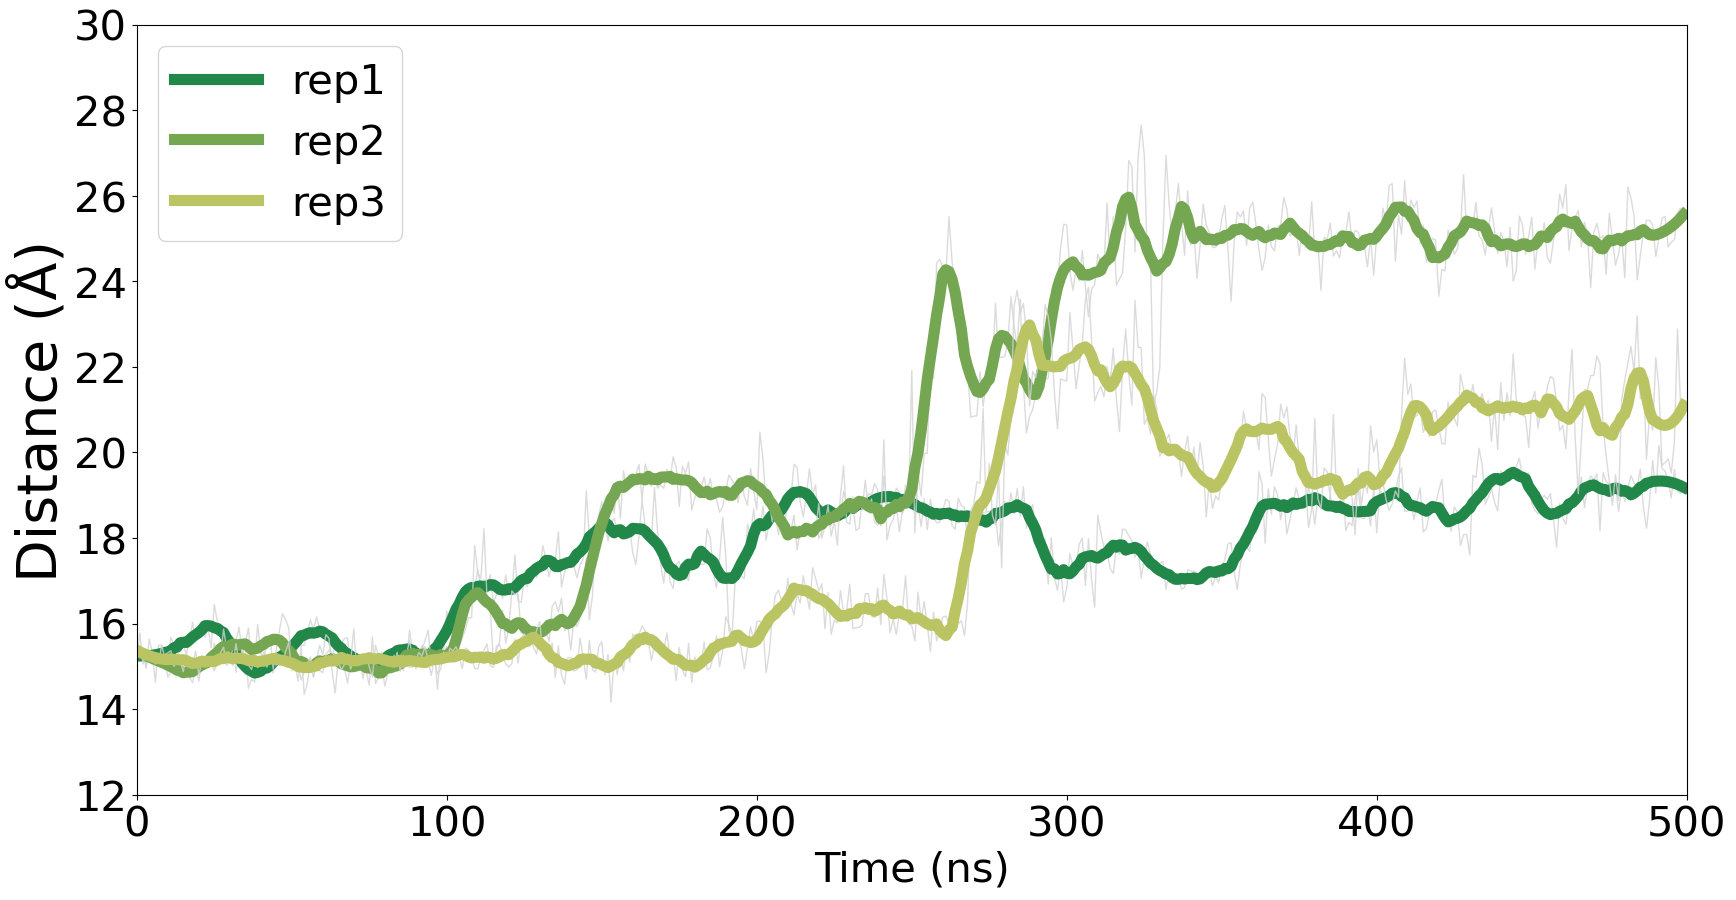

In [3]:
# List of PDB file paths for each trajectory
pdb_files = ["SYS1/centered_protein.pdb", "SYS1/centered_protein.pdb", "SYS1/centered_protein.pdb"]

# List of DCD/XTC file paths for each trajectory
dcd_files = ["SYS1/rep1.dcd", "SYS1/rep2.dcd", "SYS1/rep3.dcd"]

# List of tuples, each containing two strings specifying the atom selections for distance calculation
selections = [('segid PROF and name CA', 'chainID L')] * 3

# Output file path to save the generated plot
output_file = "figure4A.pdf"

# Title of the plot
title = ""

# List of colors for each trajectory plot
colors = ["#21884A", "#75A752", "#BBC463"]

color_line = "lightgray"

# Call the plot_distances function with the specified parameters
plot_distances(pdb_files, dcd_files, selections, output_file, title, color_line, colors)

### Figure 4B: (control, P395/FWX) - Orthosteric ligand distance to protein center

C:\Users\Gio\anaconda3\envs\mda\Lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


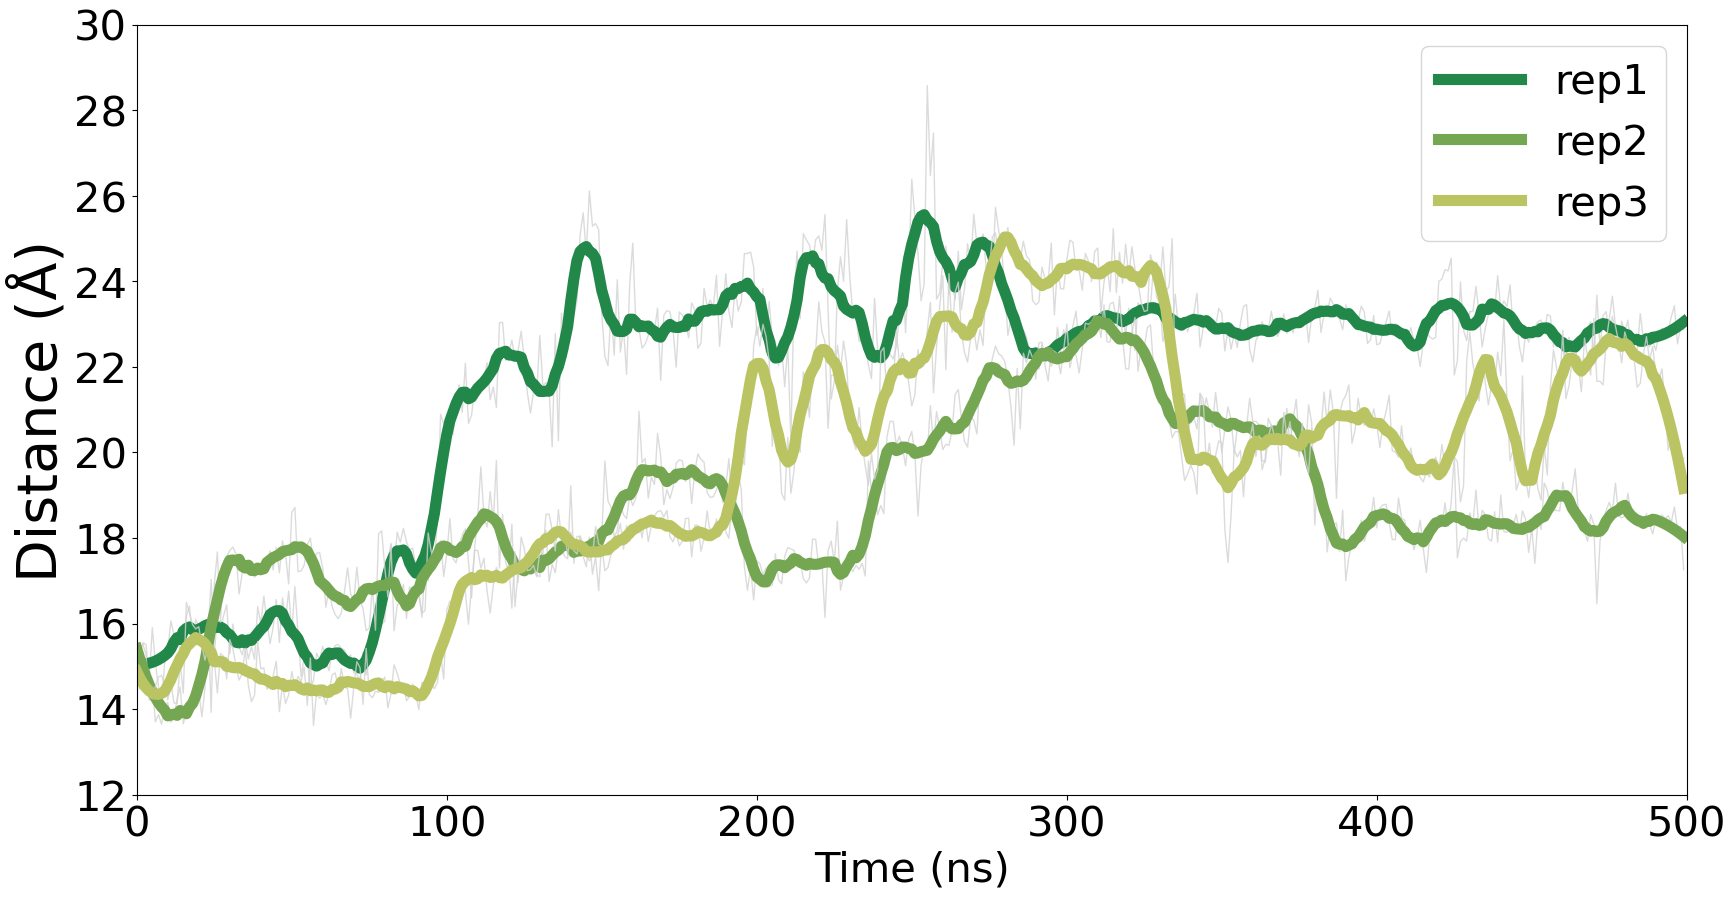

In [4]:
# List of PDB file paths for each trajectory
pdb_files = ["SYS2/centered_protein.pdb", "SYS2/centered_protein.pdb", "SYS2/centered_protein.pdb"]

# List of DCD/XTC file paths for each trajectory
dcd_files = ["SYS2/rep1.dcd", "SYS2/rep2.dcd", "SYS2/rep3.dcd"]

# List of tuples, each containing two strings specifying the atom selections for distance calculation
selections = [('segid PROA and name CA', 'chainID L')] * 3

# Output file path to save the generated plot
output_file = "figure4B.pdf"

# Title of the plot
title = ""

# List of colors for each trajectory plot
colors = ["#21884A", "#75A752", "#BBC463"]
color_line = "lightgray"

# Call the plot_distances function with the specified parameters
plot_distances(pdb_files, dcd_files, selections, output_file, title, color_line, colors)

### Figure 4E: (PAM7/K7)  - Orthosteric ligand distance to protein center

C:\Users\Gio\anaconda3\envs\mda\Lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


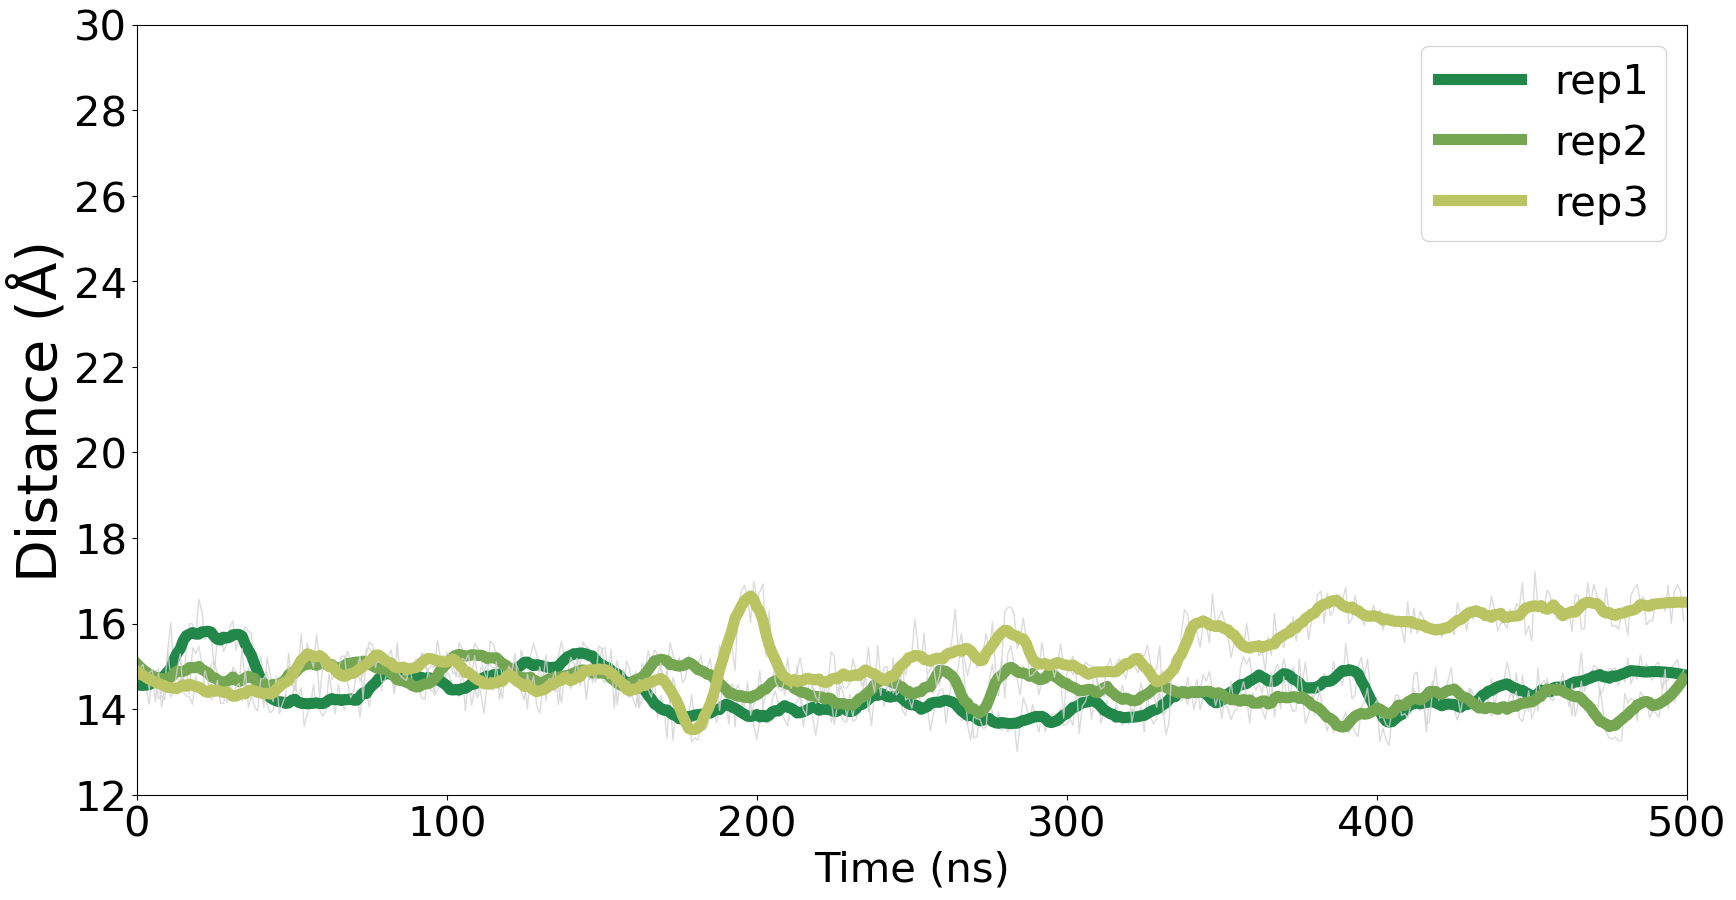

In [5]:
# List of PDB file paths for each trajectory
pdb_files = ["SYS3/centered_protein.pdb", "SYS3/centered_protein.pdb", "SYS3/centered_protein.pdb"]

# List of DCD/XTC file paths for each trajectory
dcd_files = ["SYS3/rep1.dcd","SYS3/rep2.dcd", "SYS3/rep3.dcd"]

# List of tuples, each containing two strings specifying the atom selections for distance calculation
selections = [('segid PROA and name CA', 'chainID L')] * 3

# Output file path to save the generated plot
output_file = "figure4E.pdf"

# Title of the plot
title = ""

# List of colors for each trajectory plot
colors = ["#21884A", "#75A752", "#BBC463"]
color_line = "lightgray"

# Call the plot_distances function with the specified parameters
plot_distances(pdb_files, dcd_files, selections, output_file, title, color_line, colors)

### Figure 4F: (PAM7/K7)  - PAM distance to protein center

C:\Users\Gio\anaconda3\envs\mda\Lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


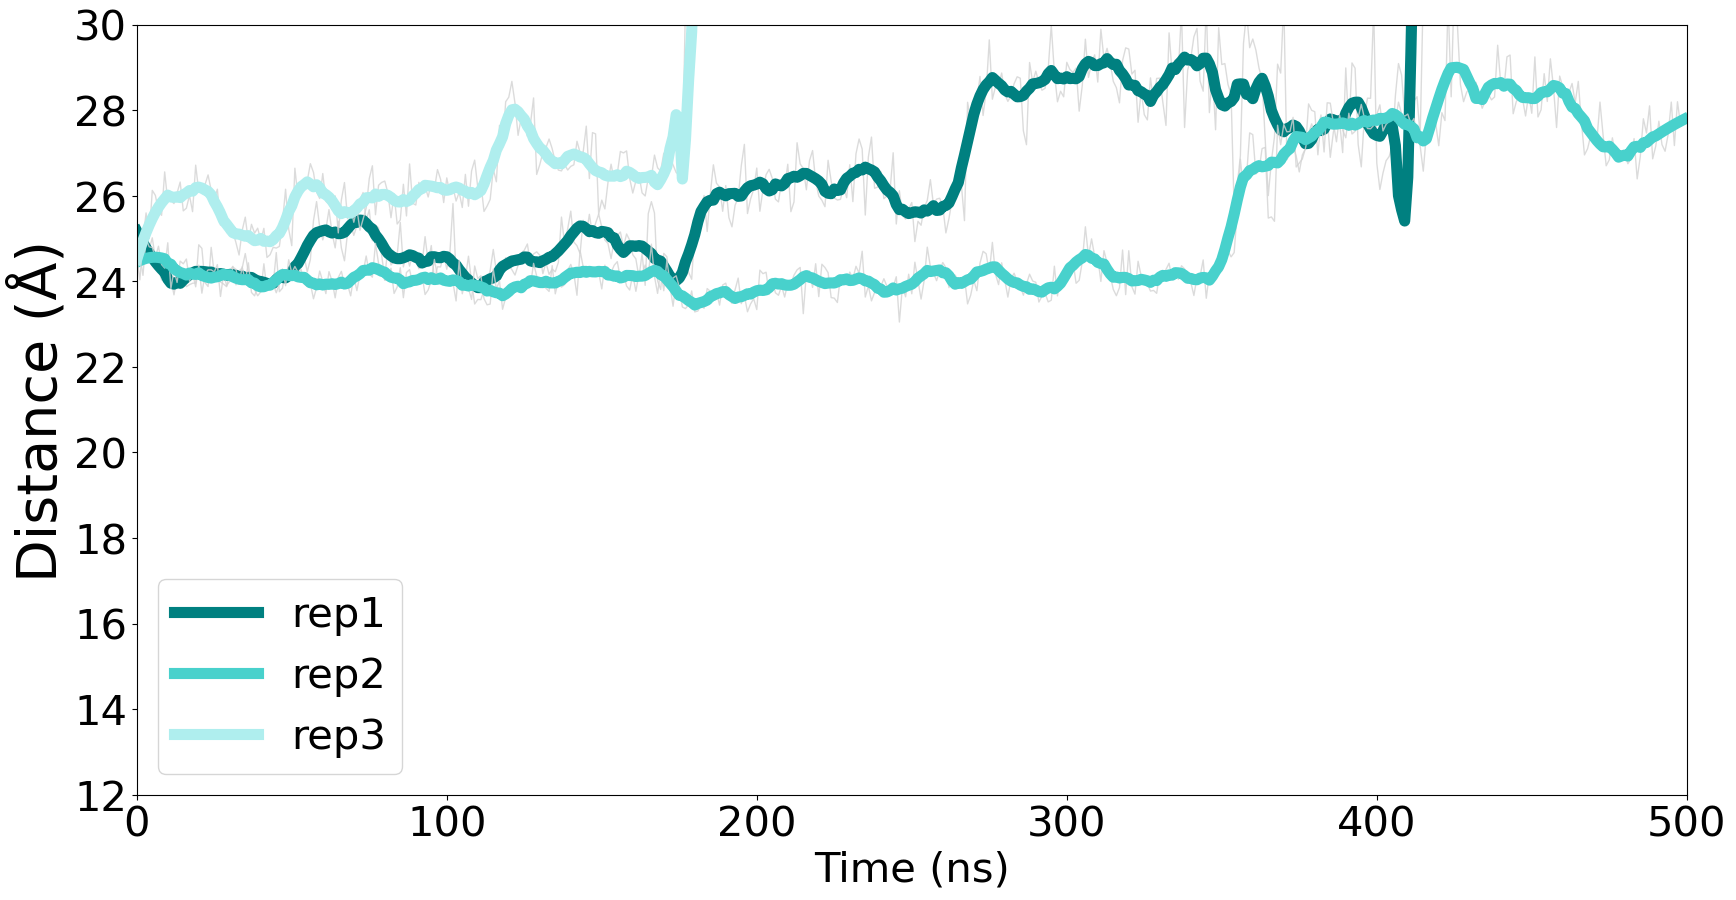

In [6]:
# List of PDB file paths for each trajectory
pdb_files = ["SYS3/centered_protein.pdb", "SYS3/centered_protein.pdb", "SYS3/centered_protein.pdb"]

# List of DCD/XTC file paths for each trajectory
dcd_files = ["SYS3/rep1.dcd","SYS3/rep2.dcd", "SYS3/rep3.dcd"]

# List of tuples, each containing two strings specifying the atom selections for distance calculation
selections = [('segid PROA and name CA', 'segid HETA')] * 3

# Output file path to save the generated plot
output_file = "figure4F.pdf"

# Title of the plot
title = ""

# List of colors for each trajectory plot
colors = ["teal", "mediumturquoise", "paleturquoise"]
color_line = "lightgray"

# Call the plot_distances function with the specified parameters
plot_distances(pdb_files, dcd_files, selections, output_file, title, color_line, colors)

### Figure 4G: (PAM7/K7) mutant W75A  - Orthosteric ligand distance to protein center

C:\Users\Gio\anaconda3\envs\mda\Lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


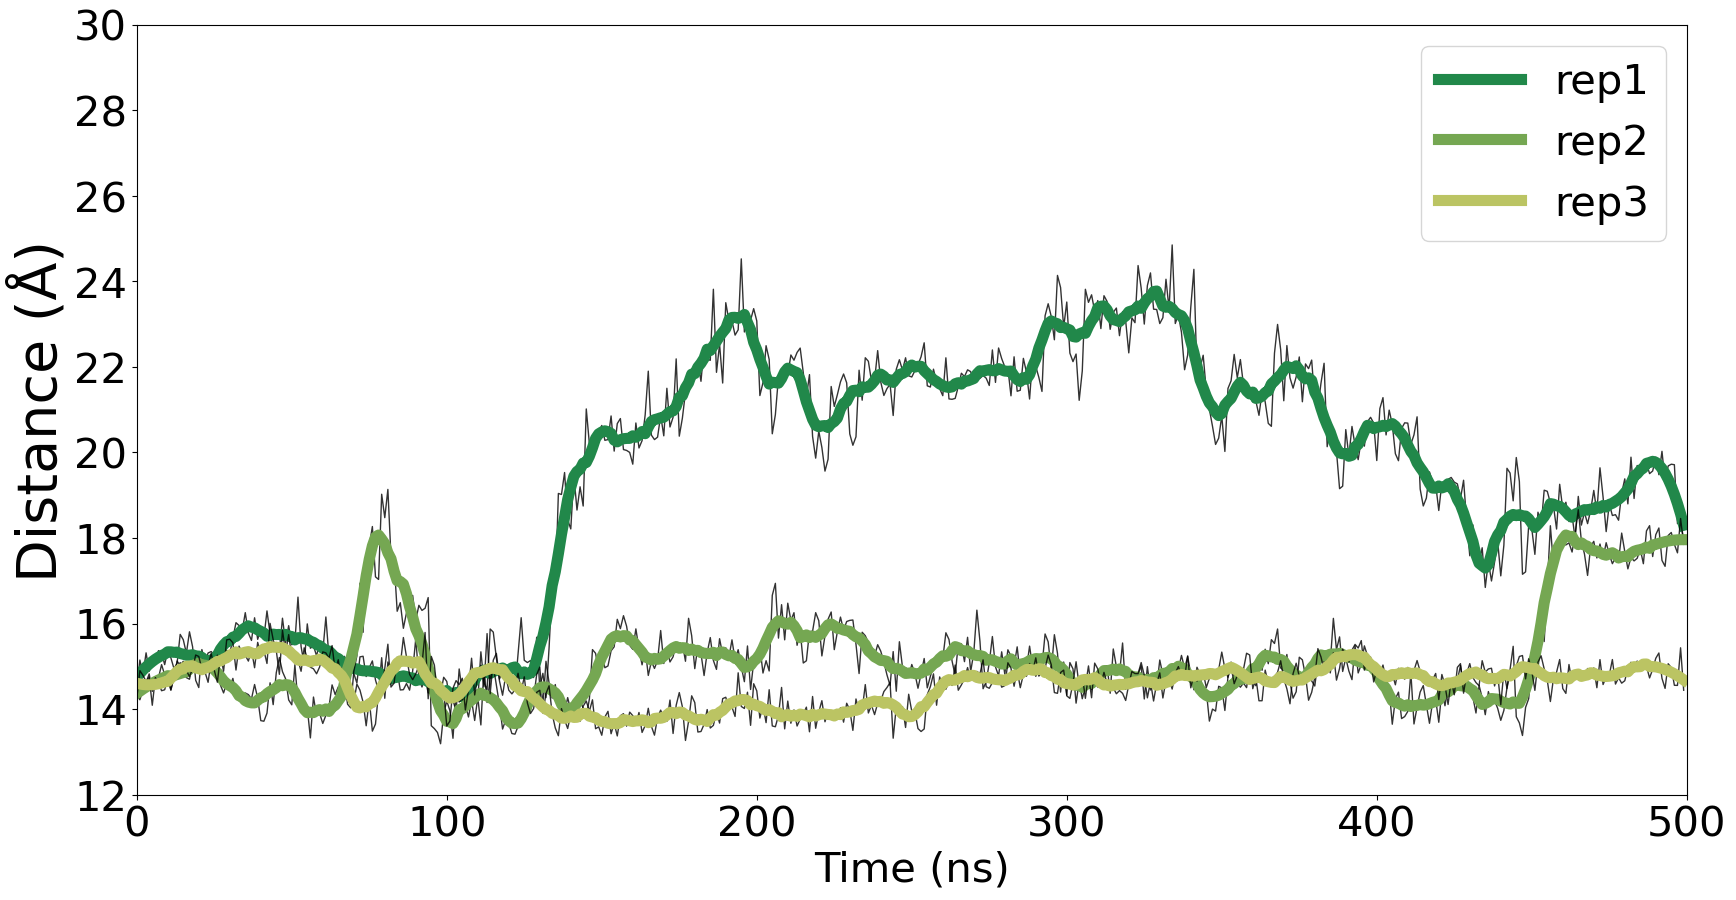

In [7]:
# List of PDB file paths for each trajectory
pdb_files = ["SYS4/centered_protein.pdb", "SYS4/centered_protein.pdb", "SYS4/centered_protein.pdb"]

# List of DCD/XTC file paths for each trajectory
dcd_files = ["SYS4/rep1.dcd","SYS4/rep2.dcd", "SYS4/rep3.dcd"]

# List of tuples, each containing two strings specifying the atom selections for distance calculation
selections = [('segid PROA and name CA', 'chainID S')] * 3

# Output file path to save the generated plot
output_file = "figure4G.pdf"

# Title of the plot
title = ""

# List of colors for each trajectory plot
colors = ["#21884A", "#75A752", "#BBC463"]
color_line = "black"

# Call the plot_distances function with the specified parameters
plot_distances(pdb_files, dcd_files, selections, output_file, title, color_line, colors)

### Figure 4H: (PAM7/K7) mutant W75A  - PAM distance to protein center

In [ ]:
# List of PDB file paths for each trajectory
pdb_files = ["SYS4/centered_protein.pdb", "SYS4/centered_protein.pdb", "SYS4/centered_protein.pdb"]

# List of DCD/XTC file paths for each trajectory
dcd_files = ["SYS4/rep1.dcd","SYS4/rep2.dcd", "SYS4/rep3.dcd"]

# List of tuples, each containing two strings specifying the atom selections for distance calculation
selections = [('segid PROA and name CA', 'chainID L')] * 3

# Output file path to save the generated plot
output_file = "figure4H.pdf"

# Title of the plot
title = ""

# List of colors for each trajectory plot
colors = ["teal", "mediumturquoise", "paleturquoise"]
color_line = "black"

# Call the plot_distances function with the specified parameters
plot_distances(pdb_files, dcd_files, selections, output_file, title, color_line, colors)

## Fraction of contacts of the predicted pose of K7 in the W75-pocket

The user has to modify:
- PDB files (x3 replicates)
- DCD or XTC files (x3 replicates)
- 2 groups of atoms to compute the contacts
- Output PDF file containing the plot
- Title for the figure
- Colors for each replicate

### Figure 4C: (PAM7/K7) - Fraction of contacts of PAM

In [ ]:
# List of PDB file paths for each trajectory
pdb_files = ["SYS3/centered_protein.pdb", "SYS3/centered_protein.pdb", "SYS3/centered_protein.pdb"]

# List of DCD/XTC file paths for each trajectory
dcd_files = ["SYS3/rep1.dcd","SYS3/rep2.dcd", "SYS3/rep3.dcd"]

# List of tuples, each containing two strings specifying the atom selections for contact analysis
selections = [('segid PROA and name CA', 'segid HETA')] * 3

# Output file path to save the generated plot
output_file = "figure4C.pdf"

# Title of the plot
title = ""

# List of colors for each trajectory plot
colors = ["teal", "mediumturquoise", "paleturquoise"]
color_line = "lightgray"

# Call the plot_distances_coordination function with the specified parameters
plot_coordination(pdb_files, dcd_files, selections, output_file, title, color_line, colors)

### Figure 4D: (PAM7/K7) mutant W75A - Fraction of contacts of PAM

In [ ]:
# List of PDB file paths for each trajectory
pdb_files = ["SYS4/centered_protein.pdb", "SYS4/centered_protein.pdb", "SYS4/centered_protein.pdb"]

# List of DCD/XTC file paths for each trajectory
dcd_files = ["SYS4/rep1.dcd","SYS4/rep2.dcd", "SYS4/rep3.dcd"]

# List of tuples, each containing two strings specifying the atom selections for contact analysis
selections = [('segid PROA and name CA', 'segid HETA')] * 3

# Output file path to save the generated plot
output_file = "figure4D.pdf"

# Title of the plot
title = ""

# List of colors for each trajectory plot
colors = ["teal", "mediumturquoise", "paleturquoise"]
color_line = "black"

# Call the plot_distances_coordination function with the specified parameters
plot_coordination(pdb_files, dcd_files, selections, output_file, title, color_line, colors)

## RMSF - Fluctuation / Flexibility
### Align trajectory to protein

The user has to modify:
- PDB file
- DCD or XTC file
- Ligand & Protein selections

In [ ]:
# Input files
pdb = "SYS1/centered_protein.pdb"
trajectory = 'SYS1/rep1.dcd'

# Selections
ligand_selection = "resname FWX"
protein_selection = "protein"
backbone_selection = "backbone"

# Load trajectory
u = mda.Universe(pdb, trajectory)

# Select the protein atoms
protein_atoms = u.select_atoms(protein_selection)

# Choose a reference frame for alignment (e.g., frame 0)
ref_frame = u.trajectory[0]

# Perform the alignment
aligner = align.AlignTraj(u, protein_atoms, select="backbone", in_memory=True)
aligner.run(start=0, stop=None, step=1)

### Compute atomic RMSF of ligand

In [ ]:
# Select the ligand atoms
ligand_atoms = u.select_atoms(ligand_selection)

# Perform the RMSF calculation for the protein atoms
rmsf_analysis_lig = rms.RMSF(ligand_atoms)
rmsf_analysis_lig.run()

# Get the RMSF values from the analysis object
rmsf_values_lig = rmsf_analysis_lig.results.rmsf

# Create an array to represent the atom indices (optional, can also use residue numbers, atom names, etc.)
atom_indices = np.arange(len(rmsf_values_lig))

# Plot the RMSF values
plt.figure(figsize=(10, 6))
plt.plot(atom_indices, rmsf_values_lig, label="RMSF",color='dodgerblue')
plt.xlabel("Ligand Atom Index")
plt.ylabel("RMSF (Å)")
plt.title("Root-Mean-Square Fluctuations of Ligand Atoms")
plt.legend()
plt.grid(True)
plt.show()

### Compute mean RMSF of ligand

In [ ]:
print('Mean RMSF lig: ',round(np.mean(rmsf_values_lig),3), ' Å')

### Compute atomic RMSF of protein for Calphas

In [ ]:
#CALCULATING RMSF
c_alphas = u.select_atoms('segid PROF and name CA')
R = rms.RMSF(c_alphas).run()


rmsf_values_prot = R.results.rmsf

# Plot the rMSF values per residue
plt.figure(figsize=(10, 6))
plt.plot(c_alphas.resids, R.rmsf, label="RMSF", color='dodgerblue')
plt.xlabel("Protein Residue Index")
plt.ylabel("Average RMSF (Å)")
plt.title("Root-Mean-Square Fluctuations per Residue of Protein")
plt.legend()
plt.grid(True)
plt.show()

### Compute mean RMSF of protein for Calphas

In [ ]:
print('Mean RMSF prot: ',round(np.mean(rmsf_values_prot),3), ' Å')

## Backbone RMSD - Fluctuation
### Align trajectory to protein

The user has to modify:
- PDB files
- DCD or XTC files

In [ ]:
# Define lists of PDB and trajectory files for each dataset
datasets = {
    "System 1: control with G-prot, P395/FWX": {
        "PDBs": ["SYS1/centered_protein.pdb", "SYS1/centered_protein.pdb", "SYS1/centered_protein.pdb"],
        "XTCs": ["SYS1/rep1.dcd", "SYS1/rep2.dcd", "SYS1/rep3.dcd"]
    },
    "System 2: control, P395/FWX": {
        "PDBs": ["SYS2/centered_protein.pdb", "SYS2/centered_protein.pdb", "SYS2/centered_protein.pdb"],
        "XTCs": ["SYS2/rep1.dcd", "SYS2/rep2.dcd", "SYS2/rep3.dcd"]
    },
    "System 2: PAM7/K7": {
        "PDBs": ["SYS3/centered_protein.pdb", "SYS3/centered_protein.pdb", "SYS3/centered_protein.pdb"],
        "XTCs": ["SYS3/rep1.dcd", "SYS3/rep2.dcd", "SYS3/rep3.dcd"]
    },
    "System 4: PAM7/K7 - mutant W75A": {
        "PDBs": ["SYS4/centered_protein.pdb", "SYS4/centered_protein.pdb", "SYS4/centered_protein.pdb"],
        "XTCs": ["SYS4/rep1.dcd", "SYS4/rep2.dcd", "SYS4/rep3.dcd"]
    }
}

# Initialize an empty dictionary to store mean RMSD values for all trajectories, split by systems
system_mean_rmsd_values = {system: [] for system in datasets.keys()}

for dataset, data in datasets.items():
    mean_rmsd_values = []  # Initialize a list to store mean RMSD values for the current dataset
    
    for PDB, XTC in zip(data["PDBs"], data["XTCs"]):
        # LOADING FILES
        u = mda.Universe(PDB, XTC)
        ref = mda.Universe(PDB)

        # RMSD OF A TRAJECTORY USING MULTIPLE SELECTIONS
        R = rms.RMSD(u,
                     u,
                     select='backbone',
                     ref_frame=0)
        R.run()

        # STORE DATA IN TABLE
        df = pd.DataFrame(R.results.rmsd, columns=['Frame', 'Time (ns)', 'Backbone'])

        # PLOTTING THE DATA IN GRAPH
        mean_rmsd = df[['Backbone']].mean(axis=1)
        mean_rmsd_values.append(mean_rmsd.mean())

    # Append the mean RMSD values for the current dataset to the dictionary
    system_mean_rmsd_values[dataset] = mean_rmsd_values

# Print mean RMSD values split by systems
print("\nMean RMSD values for all datasets and trajectories:")
for system, rmsd_values in system_mean_rmsd_values.items():
    print(f"\n{system}:")
    for i, rmsd in enumerate(rmsd_values, start=1):
        print(f"Trajectory {i}: {round(rmsd, 2)}")

#### Contact information

[Giovanna Papadopoulos](mailto:mge.pap@gmail.com)

[Brian Medel](mailto:brianmedelmo@gmail.com)